In [1]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm

In [2]:
from astroddpm.diffusion.models.network import DownResBlock, MidResBlock, NormConv2d, sinusoidal_embedding, gaussian_fourier_embedding, SineCosine
from torch.nn import functional as F
from torch import nn

In [3]:
## Relative imports
from astroddpm.runners import config_from_id
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE, ContinuousVPSDE
import astroddpm.utils.colormap_custom 
from astroddpm.datahandler.dataset import get_dataset_and_dataloader
from astroddpm.diffusion.stochastic.sde import get_sde
from astroddpm.diffusion.power_spectra.powerspec_sampler import get_ps_sampler
from astroddpm.utils.scheduler import CosineAnnealingScheduler, LinearScheduler, InversePowerLawScheduler, InverseSquareRootScheduler, StepScheduler

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/sw/nix/store/d9jbiy4kghz72ak7mija92asihk8xcja-py-torchvision-0.15.2/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
from astroddpm.moment.models import TparamMomentNetwork, MomentModel, SigmaMomentNetwork, SigmaMomentModel

In [5]:
ALL_MODELS = os.path.join(os.path.dirname(astroddpm.__file__), 'config', 'MODELS.json')

with open(ALL_MODELS, 'r') as f:
    ALL_MODELS_DICT = json.load(f)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amin = - 3
amax = 6

diffuser_ID = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine'

In [7]:
config = config_from_id(diffuser_ID)

In [8]:
config.keys()

dict_keys(['diffusion_model', 'dataloaders', 'optimizer', 'scheduler', 'ckpt_epoch', 'separate_ckpt', 'ckpt_dir', 'sample_epoch', 'sample_dir', 'sample_size', 'results_size', 'epochs', 'model_id'])

In [9]:
dataloaders_config = config['dataloaders']
dataloaders_config['batch_size'] = 128
power_spectrum_config = config['diffusion_model']['ps']
sde_config = config['diffusion_model']['sde']

In [10]:
train_dataset, test_dataset, train_dataloader, test_dataloader = get_dataset_and_dataloader(dataloaders_config)
ps_sampler = get_ps_sampler(power_spectrum_config)
sde = get_sde(sde_config)
sde.noise_level(torch.ones(1)*sde.tmin).item(), sde.noise_level(torch.ones(1)*sde.tmax).item()

(0.0031644399277865887, 152.16697692871094)

In [11]:
def train_sigma_MM(model, optimizer, train_dataloader, epochs,test_dataloader = None, ckpt_path = None, ckpt_step = 5, scheduler = None):
    train_losses = []
    test_losses = []
    progress_bar = tqdm.tqdm(range(epochs))
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            if len(batch.shape) == 3:
                batch = batch.unsqueeze(1)
            batch = batch.to(device)
            optimizer.zero_grad()
            loss = model.loss(batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)
        with torch.no_grad():
            if test_dataloader is not None:
                model.eval()
                test_loss = 0
                for batch in test_dataloader:
                    if len(batch.shape) == 3:
                        batch = batch.unsqueeze(1)
                    batch = batch.to(device)
                    loss = model.loss(batch)
                    test_loss += loss.item()
                test_loss /= len(test_dataloader)
                test_losses.append(test_loss)
        log = "Epoch {} | Train loss: {:2f} | Test loss: {:2f}".format(epoch, train_loss, test_loss)
        if scheduler is not None:
            scheduler.step()
        progress_bar.update(1)
        progress_bar.set_description(log)
        if ckpt_path is not None and (epoch % ckpt_step == 0):
            ckpt = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch": epoch, "config": model.config}
            torch.save(ckpt, os.path.join(ckpt_path, f"ckpt.pt"))
    return train_losses, test_losses

In [12]:
CKPT_PATH = '/mnt/home/dheurtel/ceph/02_checkpoints'
MODEL_ID = 'SigmaMomentModel_CMBPS'

CKPT_DIR = os.path.join(CKPT_PATH, MODEL_ID)
os.makedirs(CKPT_DIR, exist_ok=True)

In [13]:
l = os.listdir(CKPT_PATH)
l = [x for x in l if x.startswith('Moment')]
l

['MomentModel_ContinuousVPSDE_I_BPROJ_smallnoise',
 'MomentModel_ContinuousVPSDE_I_BPROJ',
 'MomentModel_ContinuousVPSDE_I_BPROJ_beta_0_0.01_beta_T_0.5_beta_schedule_cosine']

In [14]:
load_ckpt = False

if load_ckpt:
    ckpt = torch.load(os.path.join(CKPT_DIR, 'ckpt.pt'))
    config = ckpt['config']
    state_dict = ckpt['model']

In [15]:
config.keys()

dict_keys(['diffusion_model', 'dataloaders', 'optimizer', 'scheduler', 'ckpt_epoch', 'separate_ckpt', 'ckpt_dir', 'sample_epoch', 'sample_dir', 'sample_size', 'results_size', 'epochs', 'model_id'])

In [16]:
if load_ckpt:
    network = SigmaMomentNetwork(**config['network'])
    network = network.to(device)
else:
    network = SigmaMomentNetwork( in_channels = 1, dim_param = 2, in_size = 256, order = 1, num_blocks = 4, first_channels = 30, padding_mode="circular", 
             normalize="GN", group_c=1, skiprescale = True,dropout=0.0)
    network = network.to(device)

30 3


In [20]:
model = SigmaMomentModel(network, sde, ps_sampler)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

if load_ckpt:
    model.load_state_dict(state_dict)
    optimizer.load_state_dict(ckpt['optimizer'])

model= model.to(device)

In [39]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 3e-5

In [40]:
train_losses, test_losses = train_sigma_MM(model, optimizer, train_dataloader, epochs= 800,test_dataloader = test_dataloader, ckpt_path = CKPT_DIR, ckpt_step = 5)

  0%|          | 0/800 [00:00<?, ?it/s]

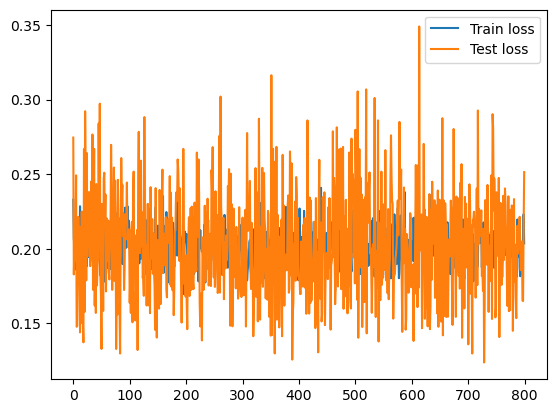

In [41]:
## Plot the losses

plt.plot(train_losses, label = "Train loss")
plt.plot(test_losses, label = "Test loss")
plt.legend()
plt.show()

In [51]:
## Plot a few guesses.

model.eval()
target_list = []
out_list = []
for _ in range(30):
    with torch.no_grad():
        batch = next(iter(test_dataloader))
        batch = batch.to(device)
        #noise_level = 0.1
        #T = sde.get_closest_timestep(noise_level)
        if len(batch.shape) == 3:
            batch = batch.unsqueeze(1)
        #timesteps = T.repeat(batch.shape[0],1).to(device)
        log_noise_level = (torch.rand(batch.shape[0],1).to(device)-1/2)*5
        noise_level = torch.exp(log_noise_level)
        timesteps = sde.get_closest_timestep(noise_level)

        rphi = torch.rand(batch.shape[0],2).to(device)*2 - 1
        phi = ps_sampler.unscale_phi(rphi)
        ps_tensor = ps_sampler(phi)
        batch_tilde, _ , _ = sde.sampling(batch, timesteps, torch.sqrt(ps_tensor))
        out = model.network(batch_tilde)
        target = torch.concatenate([rphi, log_noise_level], dim = 1)

        out = out.cpu()
        target = target.cpu()

        target_list.append(target)
        out_list.append(out)

In [52]:
all_targets = torch.cat(target_list, dim=0)
all_out = torch.cat(out_list, dim=0)

all_residual = all_out - all_targets

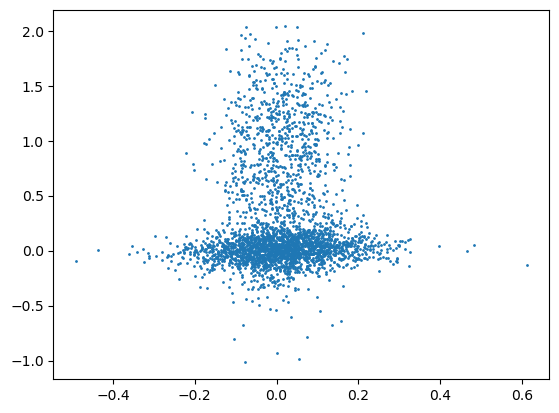

In [53]:
plt.scatter(all_residual[:,1], all_residual[:,2], s = 1)

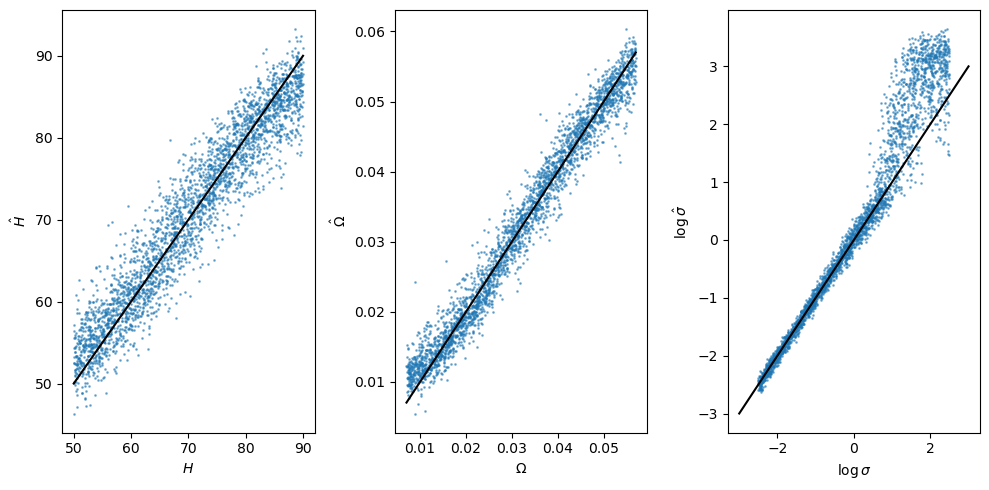

In [54]:
## Plot the empirical cdf for rphi and out
fig, ax = plt.subplots(1,3, figsize=(10,5))

phi  = model.ps.unscale_phi(all_targets[:,:2].to(device)).cpu()
true_out = model.ps.unscale_phi(all_out[:,:2].to(device)).cpu()
## Plot with small size and med alpha
ax[0].scatter(phi[:,0], true_out[:,0], s=1, alpha=0.5)
ax[0].plot([50,90],[50,90], color="black")
ax[0].set_xlabel("$H$")
ax[0].set_ylabel("$\hat H$")
omega_min, omega_max = phi[:,1].min(), phi[:,1].max()
ax[1].scatter(phi[:,1], true_out[:,1], s=1, alpha=0.5)
ax[1].plot([omega_min,omega_max],[omega_min,omega_max], color="black")
ax[1].set_xlabel("$\Omega$")
ax[1].set_ylabel("$\hat \Omega$")
ax[2].scatter(all_targets[:,2], all_out[:,2], s=1, alpha=0.5)
ax[2].plot([-3,3],[-3,3], color="black")
ax[2].set_xlabel("$\log \sigma$")
ax[2].set_ylabel("$\log \hat \sigma$")
plt.tight_layout()
plt.show()


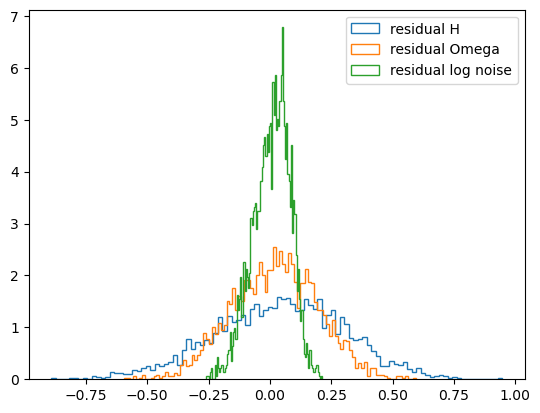

In [46]:
plt.hist(all_residual[:,0], bins = 100, density = True, histtype = "step", label = "residual H")
plt.hist(all_residual[:,1], bins = 100, density = True, histtype = "step", label = "residual Omega")
plt.hist(all_residual[:,2], bins = 100, density = True, histtype = "step", label = "residual log noise")
plt.legend()
plt.show()

In [ ]:
## Train a second order model

network2 = TparamMomentNetwork( in_channels = 1, dim_param = 2, in_size = 32, order = 2, num_blocks = 3, first_channels = 10, time_embed_dim = 100,padding_mode="circular", 
         normalize="GN", group_c=1, skiprescale = True, discretization = "continuous", embedding_mode = None, n_steps = 1000,dropout=0.0)

network2 = network2.to(device)

NameError: name 'TparamMomentNetwork' is not defined

In [ ]:
model2 = MomentModel(network2, sde, ps_sampler, conetwork = network)

optimizer2 = torch.optim.AdamW(model2.parameters(), lr=1e-3)

epochs = 1200

In [ ]:
train_losses2, test_losses2 = train(model2, optimizer2, train_dataloader, epochs = 400,test_dataloader = test_dataloader, ckpt_path = CKPT_DIR, ckpt_step = 5)

  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

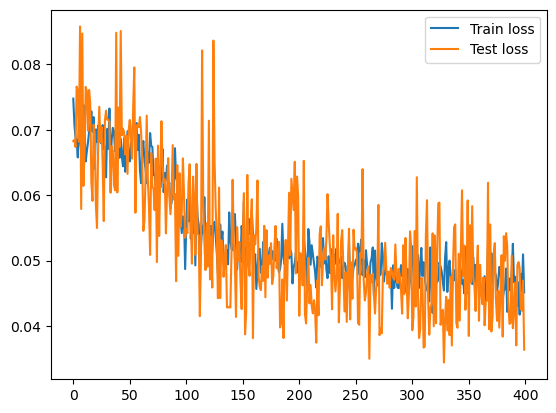

In [ ]:
## Plot the losses

plt.plot(train_losses2, label = "Train loss")
plt.plot(test_losses2, label = "Test loss")
plt.legend()

In [ ]:
rphi_0_grid = torch.linspace(-1, 1, 10)
rphi_1_grid = torch.linspace(-1, 1, 10)

rphi_0_grid, rphi_1_grid = torch.meshgrid(rphi_0_grid, rphi_1_grid)

rphi_grid = torch.stack([rphi_0_grid, rphi_1_grid], dim = -1)

In [ ]:
rphi_grid = rphi_grid.reshape(-1,2)

In [ ]:
rphi_grid_list = rphi_grid.split(1)

In [ ]:
model.eval()
rphi_0_grid = torch.linspace(-1, 1, 10)
results = []
for rphi_0 in rphi_0_grid:
    with torch.no_grad():
        batch = next(iter(test_dataloader))
        batch = batch.to(device)
        noise_level = 0.1
        T = sde.get_closest_timestep(noise_level)
        if len(batch.shape) == 3:
            batch = batch.unsqueeze(1)
        timesteps = T.repeat(batch.shape[0],1).to(device)
        rphi_test = torch.tensor([rphi_0, 0.0]).to(device).reshape(1,2).repeat(batch.shape[0],1)
        phi_test = ps_sampler.unscale_phi(rphi_test)
        ps_test = ps_sampler(phi_test)
        batch_tilde, _ , _ = sde.sampling(batch, timesteps, torch.sqrt(ps_test))
        out = model.network(batch_tilde, timesteps)
        results.append(out.cpu().detach().numpy())
        residual = (out - rphi_test).cpu()

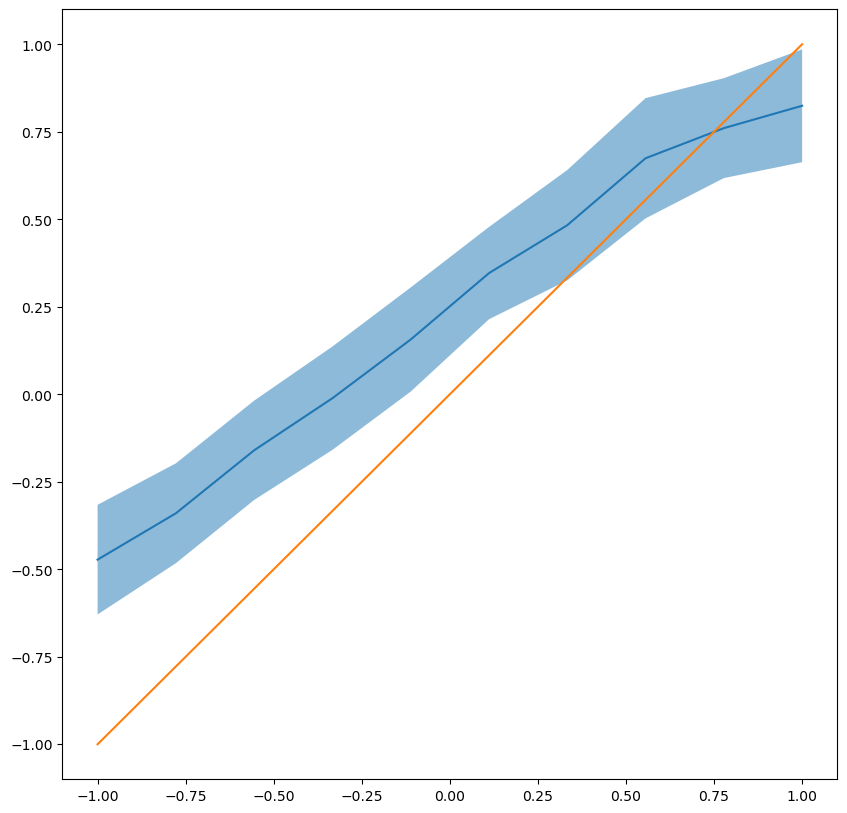

In [ ]:
## Plot the results. Plot the mean of the model as a function of the true mean (for rphi_0)

fig, ax = plt.subplots(figsize = (10,10))

results = [res.reshape(1,100,2) for res in results]
results = np.concatenate(results, axis = 0)

ax.plot(rphi_0_grid, results[:, :, 0].mean(axis = 1), label = "Model mean")
ax.fill_between(rphi_0_grid, results[:, :, 0].mean(axis = 1) - results[:, :, 0].std(axis = 1), results[:, :, 0].mean(axis = 1) + results[:, :, 0].std(axis = 1), alpha = 0.5)
ax.plot(rphi_0_grid, rphi_0_grid, '-' ,label = "True mean")

In [ ]:
## Sample one phi, build some noisy x and compute the estimated mean and covariance matrix of the posterior given x

model.eval()
model2.eval()

with torch.no_grad():
    batch = next(iter(test_dataloader))
    batch = batch.to(device)
    noise_level = 0.02
    T = sde.get_closest_timestep(noise_level)
    if len(batch.shape) == 3:
        batch = batch.unsqueeze(1)
    timesteps = T.repeat(batch.shape[0],1).to(device)
    ps_tensor, phi = ps_sampler.sample_ps(batch.shape[0])
    batch_tilde, _ , _ = sde.sampling(batch, timesteps, torch.sqrt(ps_tensor))
    rphi = ps_sampler.rescale_phi(phi)
    mean = model.network(batch_tilde, timesteps)
    cov = model2.network(batch_tilde, timesteps)
rphi = rphi.cpu()
mean = mean.cpu()
cov = cov.cpu()

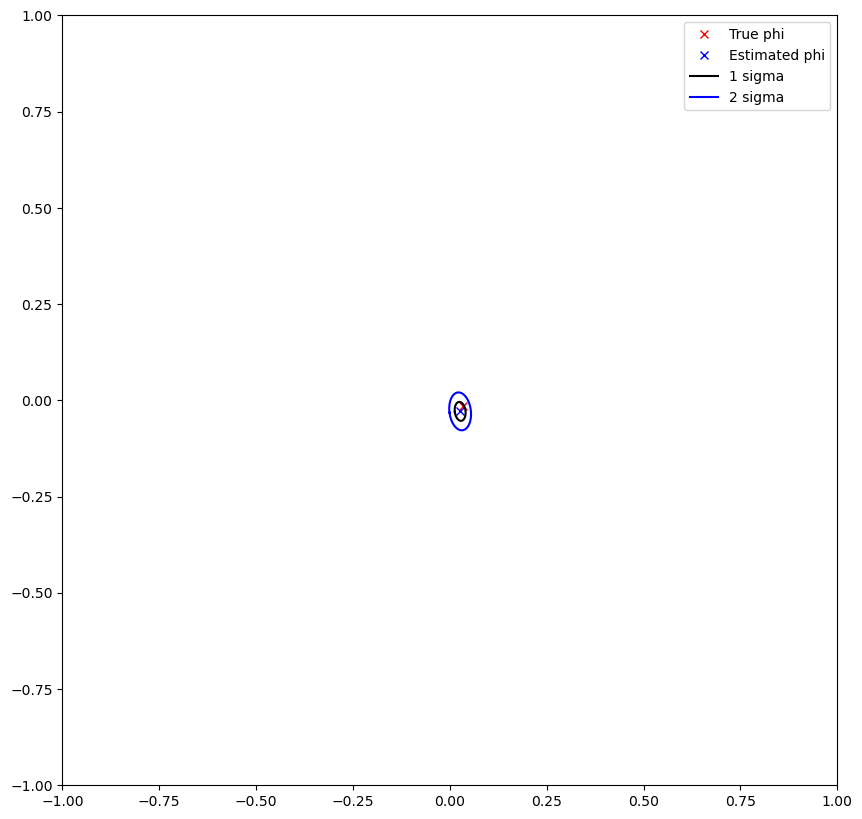

In [ ]:
idx = 0

## Plot a 2D image with a red cross at the true value of phi and a blue cross at the estimated value of phi and two ellipses corresponding to 1 sigma and 2 sigma confidence intervals
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.plot(rphi[idx,0], rphi[idx,1], 'rx', label = "True phi")
ax.plot(mean[idx,0], mean[idx,1], 'bx', label = "Estimated phi")

## Get the points to plot the ellipses
thetas = np.linspace(0, 2*np.pi, 100)
x = np.cos(thetas)
y = np.sin(thetas)
points = np.vstack((x,y)).T

## Compute the eigenvalues and eigenvectors of the covariance matrix

eigvals, eigvecs = np.linalg.eig(cov[idx].cpu().numpy())

## Plot the 1 sigma ellipse

ellipse = np.sqrt(eigvals[0])*np.outer(points[:,0], eigvecs[:,0]) + np.sqrt(eigvals[1])*np.outer(points[:,1], eigvecs[:,1])
ax.plot(ellipse[:,0] + mean[idx,0].item(), ellipse[:,1] + mean[idx,1].item(), 'black', label = "1 sigma")

## Plot the 2 sigma ellipse

ellipse = 2*np.sqrt(eigvals[0])*np.outer(points[:,0], eigvecs[:,0]) + 2*np.sqrt(eigvals[1])*np.outer(points[:,1], eigvecs[:,1])
ax.plot(ellipse[:,0] + mean[idx,0].item(), ellipse[:,1] + mean[idx,1].item(), 'b', label = "2 sigma")
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.legend()